In [3]:
import warnings
warnings.filterwarnings('ignore')

import os
from os import listdir
import pathlib
from random import randint
import numpy as np
from numpy import asarray
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
import tensorflow_addons as tfa
from keras.utils import load_img,img_to_array
from keras.models import Sequential
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.layers import MaxPooling2D,Dropout,Dense,Input,Conv2D,Flatten,Conv2DTranspose
from keras.layers import GlobalAveragePooling2D,MaxPool2D,BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import plot_model

In [15]:
base_path = pathlib.Path().resolve()
dataset_path = base_path /'Dataset'


folder = str(dataset_path)

if not dataset_path.exists():
    raise FileNotFoundError(f"Dataset folder not found at: {dataset_path}")

for file in os.listdir(folder):
    print(file)


.DS_Store
VeryMildDemented
ModerateDemented
MildDemented
NonDemented


In [19]:
image_path = dataset_path / 'MildDemented' / 'mildDem1.jpg'

<PIL.Image.Image image mode=RGB size=176x208 at 0x177501690>


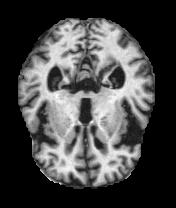

In [20]:
photo = load_img(image_path)
print(photo)
photo

In [22]:
import shutil
import os

#dataset_path = '/Users/qianhele/Desktop/Alzheimer_Dataset'

for file in os.listdir(folder):
    file_path = os.path.join(folder, file)
    if file == '.DS_Store':
        os.remove(file_path)


In [23]:
for file in listdir(folder):
    print(file)

VeryMildDemented
ModerateDemented
MildDemented
NonDemented


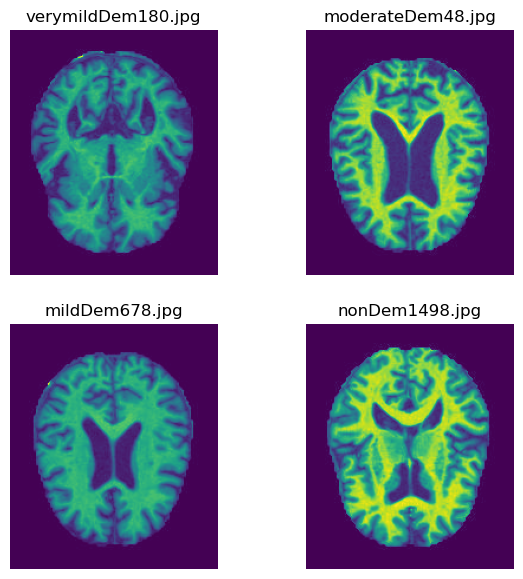

In [24]:
plt.figure(figsize=(7,7),)
j =0
for file in listdir(folder):
    i =0
    for image in listdir(folder + '/'+file):
        if i ==1:
            break;
        img = imread(folder +'/' + file + '/' + image)
        ax = plt.subplot(2,2,j+1)
        plt.imshow(img)
        plt.title(image)
        plt.axis('off')
        j = j+1
        i = i +1
plt.show()

In [25]:
# counting the number of images in each category
for file in listdir(folder):
    i =0
    for image in listdir(folder + '/'+file):
        i = i +1
    print(file , i)

VeryMildDemented 2240
ModerateDemented 64
MildDemented 896
NonDemented 3200


#### Here we can see that the dataset is completely imbalanced with different number of images in each category

In [9]:
# Creating the image datagenerator to have more samples
IMG_SIZE = 128
DIM = (IMG_SIZE, IMG_SIZE)

ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

train_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,              # Randomly rotate images by up to 20 degrees
    width_shift_range=0.1,          # Shift the image horizontally by up to 10%
    height_shift_range=0.1,         # Shift the image vertically by up to 10%
    shear_range=0.1,                # Shear the image
    zoom_range=0.2,                 # Random zoom
    horizontal_flip=True,           # Random horizontal flip
    brightness_range=(0.8, 1.2),    # Adjust brightness
    fill_mode='nearest'             # Fill in new pixels
)
train_data_gen = train_generator.flow_from_directory(directory=folder, target_size=DIM, batch_size=6500, shuffle=False)

In [10]:
train_generator = ImageDataGenerator(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, 
                                     data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)
train_data_gen = train_generator.flow_from_directory(directory=folder, target_size=DIM, batch_size=6500, shuffle=False)

Found 6400 images belonging to 4 classes.


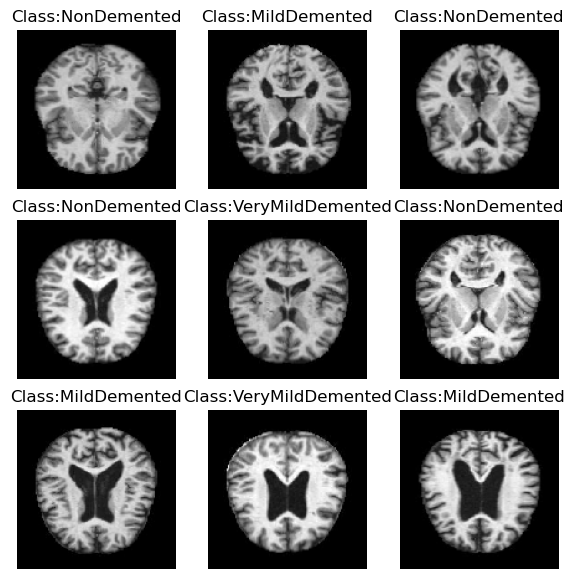

In [11]:
CLASSES = list(train_data_gen.class_indices.keys())

def show_images(generator,y_pred=None):
    # get image lables
    labels =dict(zip([0,1,2,3], CLASSES))
    
    # get a batch of images
    x,y = generator.next()
    
    # display a grid of 9 images
    plt.figure(figsize=(7, 7))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            idx = randint(0, 6400)
            plt.imshow(x[idx])
            plt.axis("off")
            plt.title("Class:{}".format(labels[np.argmax(y[idx])]))                                                    
    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))
    
# Display Train Images
show_images(train_data_gen)

In [12]:
train_data, train_labels = train_data_gen.next()

In [13]:
train_data.shape, train_labels.shape

((6400, 128, 128, 3), (6400, 4))

Since the data in each class is imbalanced we need to oversample the data

In [14]:
sm = SMOTE(random_state=42)

train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)

print(train_data.shape, train_labels.shape)

(12800, 49152) (12800, 4)


In [15]:
train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)
print(train_data.shape, train_labels.shape)

(12800, 128, 128, 3) (12800, 4)


In [16]:
train_data, test_data, train_labels,test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

train_data, val_data, train_labels,val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

In [17]:
# Defining convolutional blocks
def conv_block(filters, act='relu'):
    
    block = Sequential()
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(BatchNormalization())
    block.add(MaxPool2D())
    
    return block

In [18]:
# defining dense blocks
def dense_block(units, dropout_rate, act='relu'):
    block = Sequential()
    block.add(Dense(units, activation=act))
    block.add(BatchNormalization())
    block.add(Dropout(dropout_rate))
    
    return block

In [20]:
IMAGE_SIZE = [128,128]
act = 'relu'

In [22]:
model = Sequential([
        Input(shape=(*IMAGE_SIZE, 3)),
        Conv2D(16, 3, activation=act, padding='same'),
        Conv2D(16, 3, activation=act, padding='same'),
        MaxPool2D(),
        conv_block(32),
        conv_block(64),
        conv_block(128),
        Dropout(0.2),
        conv_block(256),
        Dropout(0.2),
        Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        Dense(4, activation='softmax')        
    ], name = "cnn_model")

In [23]:
METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc'), 
           tfa.metrics.F1Score(num_classes=4)]

model.compile(optimizer='adam',
              loss=tf.losses.CategoricalCrossentropy(),
              metrics=METRICS)

model.summary()

Model: "cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 128, 128, 16)      448       
                                                                 
 conv2d_11 (Conv2D)          (None, 128, 128, 16)      2320      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 64, 64, 16)        0         
 g2D)                                                            
                                                                 
 sequential_7 (Sequential)   (None, 32, 32, 32)        14016     
                                                                 
 sequential_8 (Sequential)   (None, 16, 16, 64)        55680     
                                                                 
 sequential_9 (Sequential)   (None, 8, 8, 128)         221952    
                                                         

## Transfer learning with Inceptionv3 model

In [24]:
inception = InceptionV3(input_shape=(128,128,3),include_top=False,weights ='imagenet')

Unfreeze more layers

In [40]:
inception.trainable = True
for layer in inception.layers[:-50]:  # Freeze all except last 50 layers (adjust as needed)
    layer.trainable = False


for layer in inception.layers: # Freeze all layers (adjust as needed)
    layer.trainable = False

In [41]:
inception_model = Sequential([
        inception,
        Dropout(0.5),
        GlobalAveragePooling2D(),
        Flatten(),
        BatchNormalization(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        BatchNormalization(),
        Dense(4, activation='softmax')        
    ], name = "inception_cnn_model")

In [42]:
METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc'), 
           tfa.metrics.F1Score(num_classes=4)]

In [43]:
inception_model.compile(optimizer='rmsprop',
                              loss=tf.losses.CategoricalCrossentropy(),
                              metrics=METRICS)

inception_model.summary()

Model: "inception_cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2, 2, 2048)        21802784  
                                                                 
 dropout_20 (Dropout)        (None, 2, 2, 2048)        0         
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 flatten_4 (Flatten)         (None, 2048)              0         
                                                                 
 batch_normalization_118 (B  (None, 2048)              8192      
 atchNormalization)                                              
                                                                 
 dense_18 (Dense)            (None, 512)       

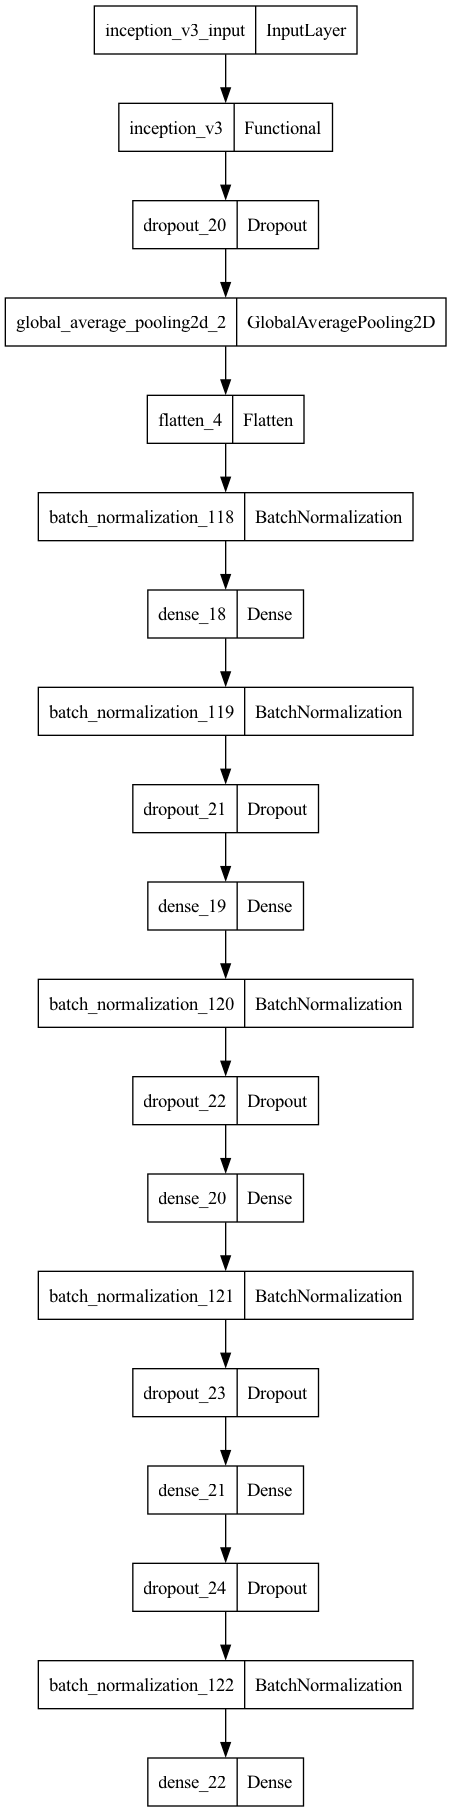

In [44]:
plot_model(inception_model)

INCEPT_CALLBACKS = [
    ModelCheckpoint(filepath='incpt_model_checkpoint.h5', save_best_only=True),
    EarlyStopping(patience=3)
]

In [45]:
INCEPT_CALLBACKS = [
    ModelCheckpoint(filepath='incpt_model_checkpoint.h5', save_best_only=True),
    EarlyStopping(patience=3, restore_best_weights=True, monitor='val_acc')
]

In [46]:
incept_history = inception_model.fit(train_data, train_labels, validation_data=(val_data, val_labels), epochs=50,callbacks= INCEPT_CALLBACKS)

Epoch 1/50
256/256 [==============================] - 78s 299ms/step - loss: 1.4009 - acc: 0.3989 - auc: 0.6674 - f1_score: 0.3983 - val_loss: 0.8713 - val_acc: 0.6089 - val_auc: 0.8757 - val_f1_score: 0.5852
Epoch 2/50
256/256 [==============================] - 83s 324ms/step - loss: 0.7920 - acc: 0.6410 - auc: 0.8870 - f1_score: 0.6370 - val_loss: 0.6814 - val_acc: 0.7197 - val_auc: 0.9295 - val_f1_score: 0.7003
Epoch 3/50
256/256 [==============================] - 91s 357ms/step - loss: 0.6064 - acc: 0.7401 - auc: 0.9354 - f1_score: 0.7411 - val_loss: 0.7840 - val_acc: 0.7158 - val_auc: 0.9218 - val_f1_score: 0.6962
Epoch 4/50
256/256 [==============================] - 90s 353ms/step - loss: 0.4887 - acc: 0.8032 - auc: 0.9577 - f1_score: 0.8046 - val_loss: 0.6110 - val_acc: 0.7598 - val_auc: 0.9485 - val_f1_score: 0.7515
Epoch 5/50
256/256 [==============================] - 88s 343ms/step - loss: 0.4032 - acc: 0.8527 - auc: 0.9705 - f1_score: 0.8532 - val_loss: 0.4842 - val_acc: 0.8

In [50]:
incept_test_scores = inception_model.evaluate(test_data, test_labels)
print("Testing Accuracy: %.2f%%"%(incept_test_scores[1] * 100))

80/80 [==============================] - 30s 372ms/step - loss: 0.2852 - acc: 0.9141 - auc: 0.9860 - f1_score: 0.9138
Testing Accuracy: 91.41%


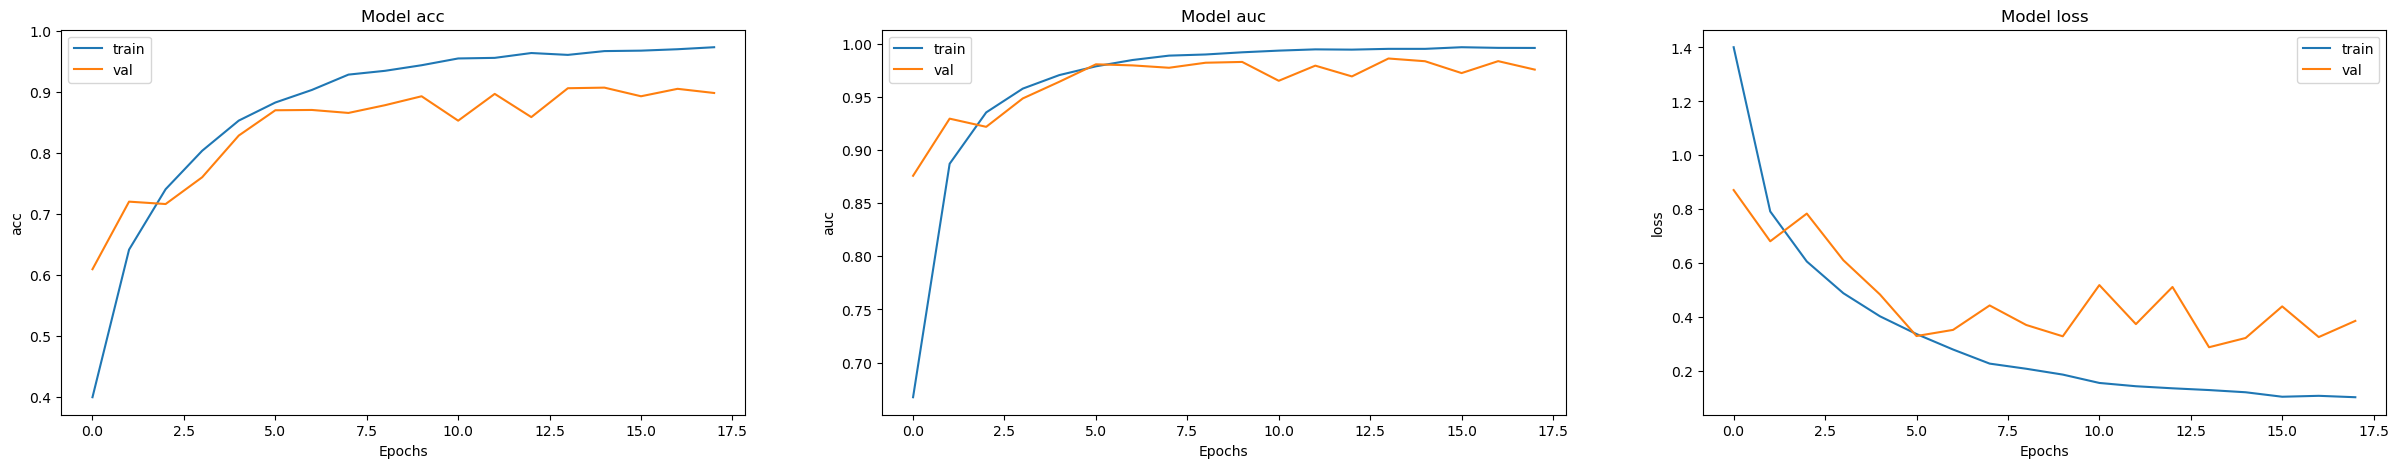

In [51]:
#Plotting the trend of the metrics during training

fig, ax = plt.subplots(1, 3, figsize = (30, 5))
ax = ax.ravel()

for i, metric in enumerate(["acc", "auc", "loss"]):
    ax[i].plot(incept_history.history[metric])
    ax[i].plot(incept_history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])